In [2]:
# General Imports
import tensorflow as tf
import pandas as pd
import numpy as np
import random
import os

import matplotlib.pyplot as plt
import seaborn as sns

from keras.utils import plot_model
from tensorflow.keras import models
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.optimizers import legacy

from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import ModelCheckpoint

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import array_to_img
from tensorflow.keras.preprocessing.image import load_img

In [2]:
import numpy as np 
from tqdm import tqdm
import cv2
import os
import imutils



def crop_img(img):

	gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
	gray = cv2.GaussianBlur(gray, (3, 3), 0)

	thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
	thresh = cv2.erode(thresh, None, iterations=2)
	thresh = cv2.dilate(thresh, None, iterations=2)
	cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
	cnts = imutils.grab_contours(cnts)
	c = max(cnts, key=cv2.contourArea)

	extLeft = tuple(c[c[:, :, 0].argmin()][0])
	extRight = tuple(c[c[:, :, 0].argmax()][0])
	extTop = tuple(c[c[:, :, 1].argmin()][0])
	extBot = tuple(c[c[:, :, 1].argmax()][0])
	ADD_PIXELS = 0
	new_img = img[extTop[1]-ADD_PIXELS:extBot[1]+ADD_PIXELS, extLeft[0]-ADD_PIXELS:extRight[0]+ADD_PIXELS].copy()
	
	return new_img
	
if __name__ == "__main__":
	training = "Training/"
	testing = "Testing/"
	training_dir = os.listdir(training)
	testing_dir = os.listdir(testing)
	IMG_SIZE = 256

	for dir in training_dir:
		save_path = 'cleaned/Training/'+ dir
		path = os.path.join(training,dir)
		image_dir = os.listdir(path)
		for img in image_dir:
			image = cv2.imread(os.path.join(path,img))
			new_img = crop_img(image)
			new_img = cv2.resize(new_img,(IMG_SIZE,IMG_SIZE))
			if not os.path.exists(save_path):
				os.makedirs(save_path)
			cv2.imwrite(save_path+'/'+img, new_img)
	
	for dir in testing_dir:
		save_path = 'cleaned/Testing/'+ dir
		path = os.path.join(testing,dir)
		image_dir = os.listdir(path)
		for img in image_dir:
			image = cv2.imread(os.path.join(path,img))
			new_img = crop_img(image)
			new_img = cv2.resize(new_img,(IMG_SIZE,IMG_SIZE))
			if not os.path.exists(save_path):
				os.makedirs(save_path)
			cv2.imwrite(save_path+'/'+img, new_img)

In [14]:
SAVE = False
SEED = 111

tf.keras.utils.set_random_seed(SEED)
tf.random.set_seed(SEED)
np.random.seed(SEED)

%config InlineBackend.figure_format = 'retina'
plt.rcParams["figure.figsize"] = (16, 10)
plt.rcParams.update({'font.size': 14})

CLASS_TYPES = ['pituitary', 'notumor', 'meningioma', 'glioma']
N_TYPES = len(CLASS_TYPES)

In [10]:
import os

def get_data_labels(directory):
    data_paths = []
    data_labels = []
    
    for label in os.listdir(directory):
        label_dir = os.path.join(directory, label)
        if os.path.isdir(label_dir):
            for image_name in os.listdir(label_dir):
                image_path = os.path.join(label_dir, image_name)
                data_paths.append(image_path)
                data_labels.append(label)
    
    return data_paths, data_labels


In [11]:
USER_PATH = r"./cleaned"
train_dir = USER_PATH + r'/Training/'
test_dir = USER_PATH + r'/Testing/'

train_paths, train_labels = get_data_labels(train_dir)
test_paths, test_labels = get_data_labels(test_dir)

print('Training')
print(f'Number of Paths: {len(train_paths)}')
print(f'Number of Labels: {len(train_labels)}')
print('\nTesting')
print(f'Number of Paths: {len(test_paths)}')
print(f'Number of Labels: {len(test_labels)}')

Training
Number of Paths: 5712
Number of Labels: 5712

Testing
Number of Paths: 1311
Number of Labels: 1311


In [7]:
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter

def show_images(image_paths, labels, im_size=350, figsize=(13, 10), index_list=None):
    if index_list is None:
        index_list = list(range(12))

    fig, axes = plt.subplots(3, 4, figsize=figsize)
    axes = axes.flatten() 
    top_view_indices = index_list[:4]     
    side_view_indices = index_list[4:8]     
    back_view_indices = index_list[8:12]    

    views = [top_view_indices, side_view_indices, back_view_indices]
    view_labels = ['Top View', 'Side View', 'Back View']

    for row, view_indices in enumerate(views):
        for i, idx in enumerate(view_indices):
            img = cv2.imread(image_paths[idx])
            img = cv2.resize(img, (im_size, im_size))
            axes[row * 4 + i].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
            axes[row * 4 + i].axis('off') 
            label = labels[idx]
            freq = Counter(labels)[label] 
            axes[row * 4 + i].set_title(f"{label} (Count: {freq})", fontsize=10)

    plt.tight_layout()
    plt.suptitle("Image Views with Labels and Frequencies", fontsize=16, y=1.02)
    plt.show()



In [12]:
image_size = (150, 150)
batch_size = 32

In [15]:
train_datagen = ImageDataGenerator(rescale=1./255,
                                   rotation_range=10,
                                   brightness_range=(0.85, 1.15),
                                   width_shift_range=0.002,
                                   height_shift_range=0.002,
                                   shear_range=12.5,
                                   zoom_range=0,
                                   horizontal_flip=True,
                                   vertical_flip=False,
                                   fill_mode="nearest")
train_generator = train_datagen.flow_from_directory(train_dir,
                                                    target_size=image_size,
                                                    batch_size=batch_size,
                                                    class_mode="categorical",
                                                    seed=SEED)
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(test_dir,
                                                  target_size=image_size,
                                                  batch_size=batch_size,
                                                  class_mode="categorical",
                                                  shuffle=False,
                                                  seed=SEED)

Found 5712 images belonging to 4 classes.
Found 1311 images belonging to 4 classes.


In [16]:
class_indices_train = train_generator.class_indices
class_indices_train_list = list(train_generator.class_indices.keys())

print("Categorical types for the training data:")
print(class_indices_train)

Categorical types for the training data:
{'glioma': 0, 'meningioma': 1, 'notumor': 2, 'pituitary': 3}


In [17]:
image_shape = (image_size[0], image_size[1], 3)
epochs = 40
steps_per_epoch = train_generator.samples // batch_size
validation_steps = test_generator.samples // batch_size

print(f'Image shape: {image_shape}')
print(f'Epochs: {epochs}')
print(f'Batch size: {batch_size}')
print(f'Steps Per Epoch: {steps_per_epoch}')
print(f'Validation steps: {validation_steps}')

Image shape: (150, 150, 3)
Epochs: 40
Batch size: 32
Steps Per Epoch: 178
Validation steps: 40


In [13]:
from keras.optimizers import Adam  

model = models.Sequential([
    
    Conv2D(32, (4, 4), activation="relu", input_shape=image_shape),
    MaxPooling2D(pool_size=(3, 3)),

    Conv2D(64, (4, 4), activation="relu"),
    MaxPooling2D(pool_size=(3, 3)),

    Conv2D(128, (4, 4), activation="relu"),
    MaxPooling2D(pool_size=(3, 3)),

    Conv2D(128, (4, 4), activation="relu"),
    Flatten(),

    Dense(512, activation="relu"),
    Dropout(0.5, seed=SEED),
    Dense(N_TYPES, activation="softmax")
])

model.summary()

optimizer = Adam(learning_rate=0.001, beta_1=0.869, beta_2=0.995)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

C:\Users\kusha\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 147, 147, 32)        │           1,568 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 49, 49, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 46, 46, 64)          │          32,832 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 15, 15, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 12, 12, 128)         │         131,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 4, 4, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 1, 1, 128)           │         262,272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │          66,048 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 4)                   │           2,052 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 495,972 (1.89 MB)

 Trainable params: 495,972 (1.89 MB)

 Non-trainable params: 0 (0.00 B)

In [14]:
model_es = EarlyStopping(monitor='loss', min_delta=1e-9, patience=8, verbose=True)
model_rlr = ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=5, verbose=True)

history = model.fit(train_generator,
                    steps_per_epoch=steps_per_epoch,
                    epochs=epochs,
                    validation_data=test_generator,
                    validation_steps=validation_steps,
                    callbacks=[model_es, model_rlr])

Epoch 1/40


C:\Users\kusha\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


178/178 ━━━━━━━━━━━━━━━━━━━━ 164s 880ms/step - accuracy: 0.3662 - loss: 1.2314 - val_accuracy: 0.7102 - val_loss: 0.7264 - learning_rate: 0.0010
Epoch 2/40
  1/178 ━━━━━━━━━━━━━━━━━━━━ 37s 210ms/step - accuracy: 0.6562 - loss: 0.8571

C:\Users\kusha\anaconda3\Lib\contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6562 - loss: 0.8571 - val_accuracy: 0.7419 - val_loss: 0.5821 - learning_rate: 0.0010
Epoch 3/40
178/178 ━━━━━━━━━━━━━━━━━━━━ 80s 440ms/step - accuracy: 0.7149 - loss: 0.6954 - val_accuracy: 0.7688 - val_loss: 0.5970 - learning_rate: 0.0010
Epoch 4/40
178/178 ━━━━━━━━━━━━━━━━━━━━ 0s 904us/step - accuracy: 0.7812 - loss: 0.5619 - val_accuracy: 0.9677 - val_loss: 0.1045 - learning_rate: 0.0010
Epoch 5/40
178/178 ━━━━━━━━━━━━━━━━━━━━ 82s 448ms/step - accuracy: 0.8205 - loss: 0.4851 - val_accuracy: 0.8023 - val_loss: 0.6062 - learning_rate: 0.0010
Epoch 6/40
178/178 ━━━━━━━━━━━━━━━━━━━━ 0s 839us/step - accuracy: 0.9062 - loss: 0.3374 - val_accuracy: 1.0000 - val_loss: 0.1580 - learning_rate: 0.0010
Epoch 7/40
178/178 ━━━━━━━━━━━━━━━━━━━━ 86s 472ms/step - accuracy: 0.8792 - loss: 0.3276 - val_accuracy: 0.8695 - val_loss: 0.3677 - learning_rate: 0.0010
Epoch 8/40
178/178 ━━━━━━━━━━━━━━━━━━━━ 0s 795us/step - accuracy: 0.9062 - loss: 0.261

In [17]:
loss, accuracy = model.evaluate(test_generator)
print(f"Loss: {loss:0.5f}")
print(f"Accuracy: {accuracy:0.5f}")

178/178 ━━━━━━━━━━━━━━━━━━━━ 41s 230ms/step - accuracy: 0.9875 - loss: 0.0401
Loss: 0.04375
Accuracy: 0.98631


In [22]:
model.save('best_acc.keras')

In [4]:
from tensorflow.keras.models import load_model


In [9]:
nm = load_model('best_acc.keras')

In [18]:
predict = nm.predict(test_generator)

C:\Users\kusha\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


41/41 ━━━━━━━━━━━━━━━━━━━━ 9s 191ms/step


In [19]:
predict1 = nm.predict(train_generator)

179/179 ━━━━━━━━━━━━━━━━━━━━ 101s 567ms/step


In [20]:
from sklearn.metrics import confusion_matrix

In [31]:
predicted_classes = np.argmax(predict, axis=1)

In [35]:
true_classes = [class_indices_train[label] for label in test_labels]


In [43]:
conf_matrix = confusion_matrix(true_classes, predicted_classes)


In [44]:
print(conf_matrix)

[[279  11   2   8]
 [  0 298   6   2]
 [  1   2 402   0]
 [  2   1   0 297]]


In [45]:
import seaborn as sns


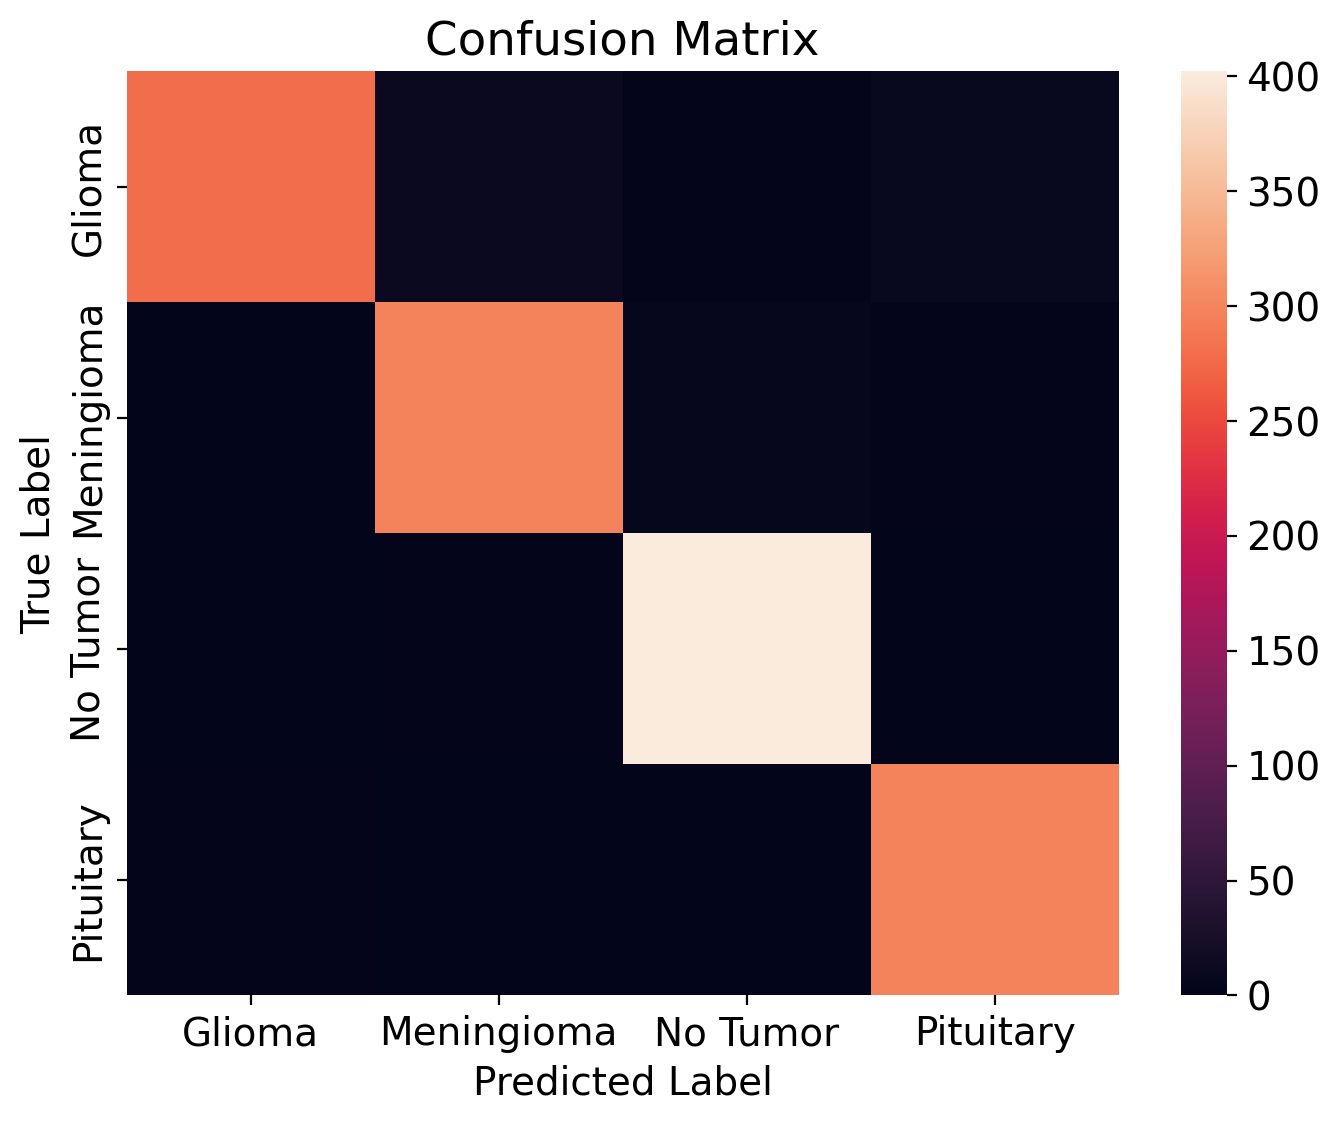

In [53]:
class_names = ['Glioma', 'Meningioma', 'No Tumor', 'Pituitary']

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, fmt='d', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

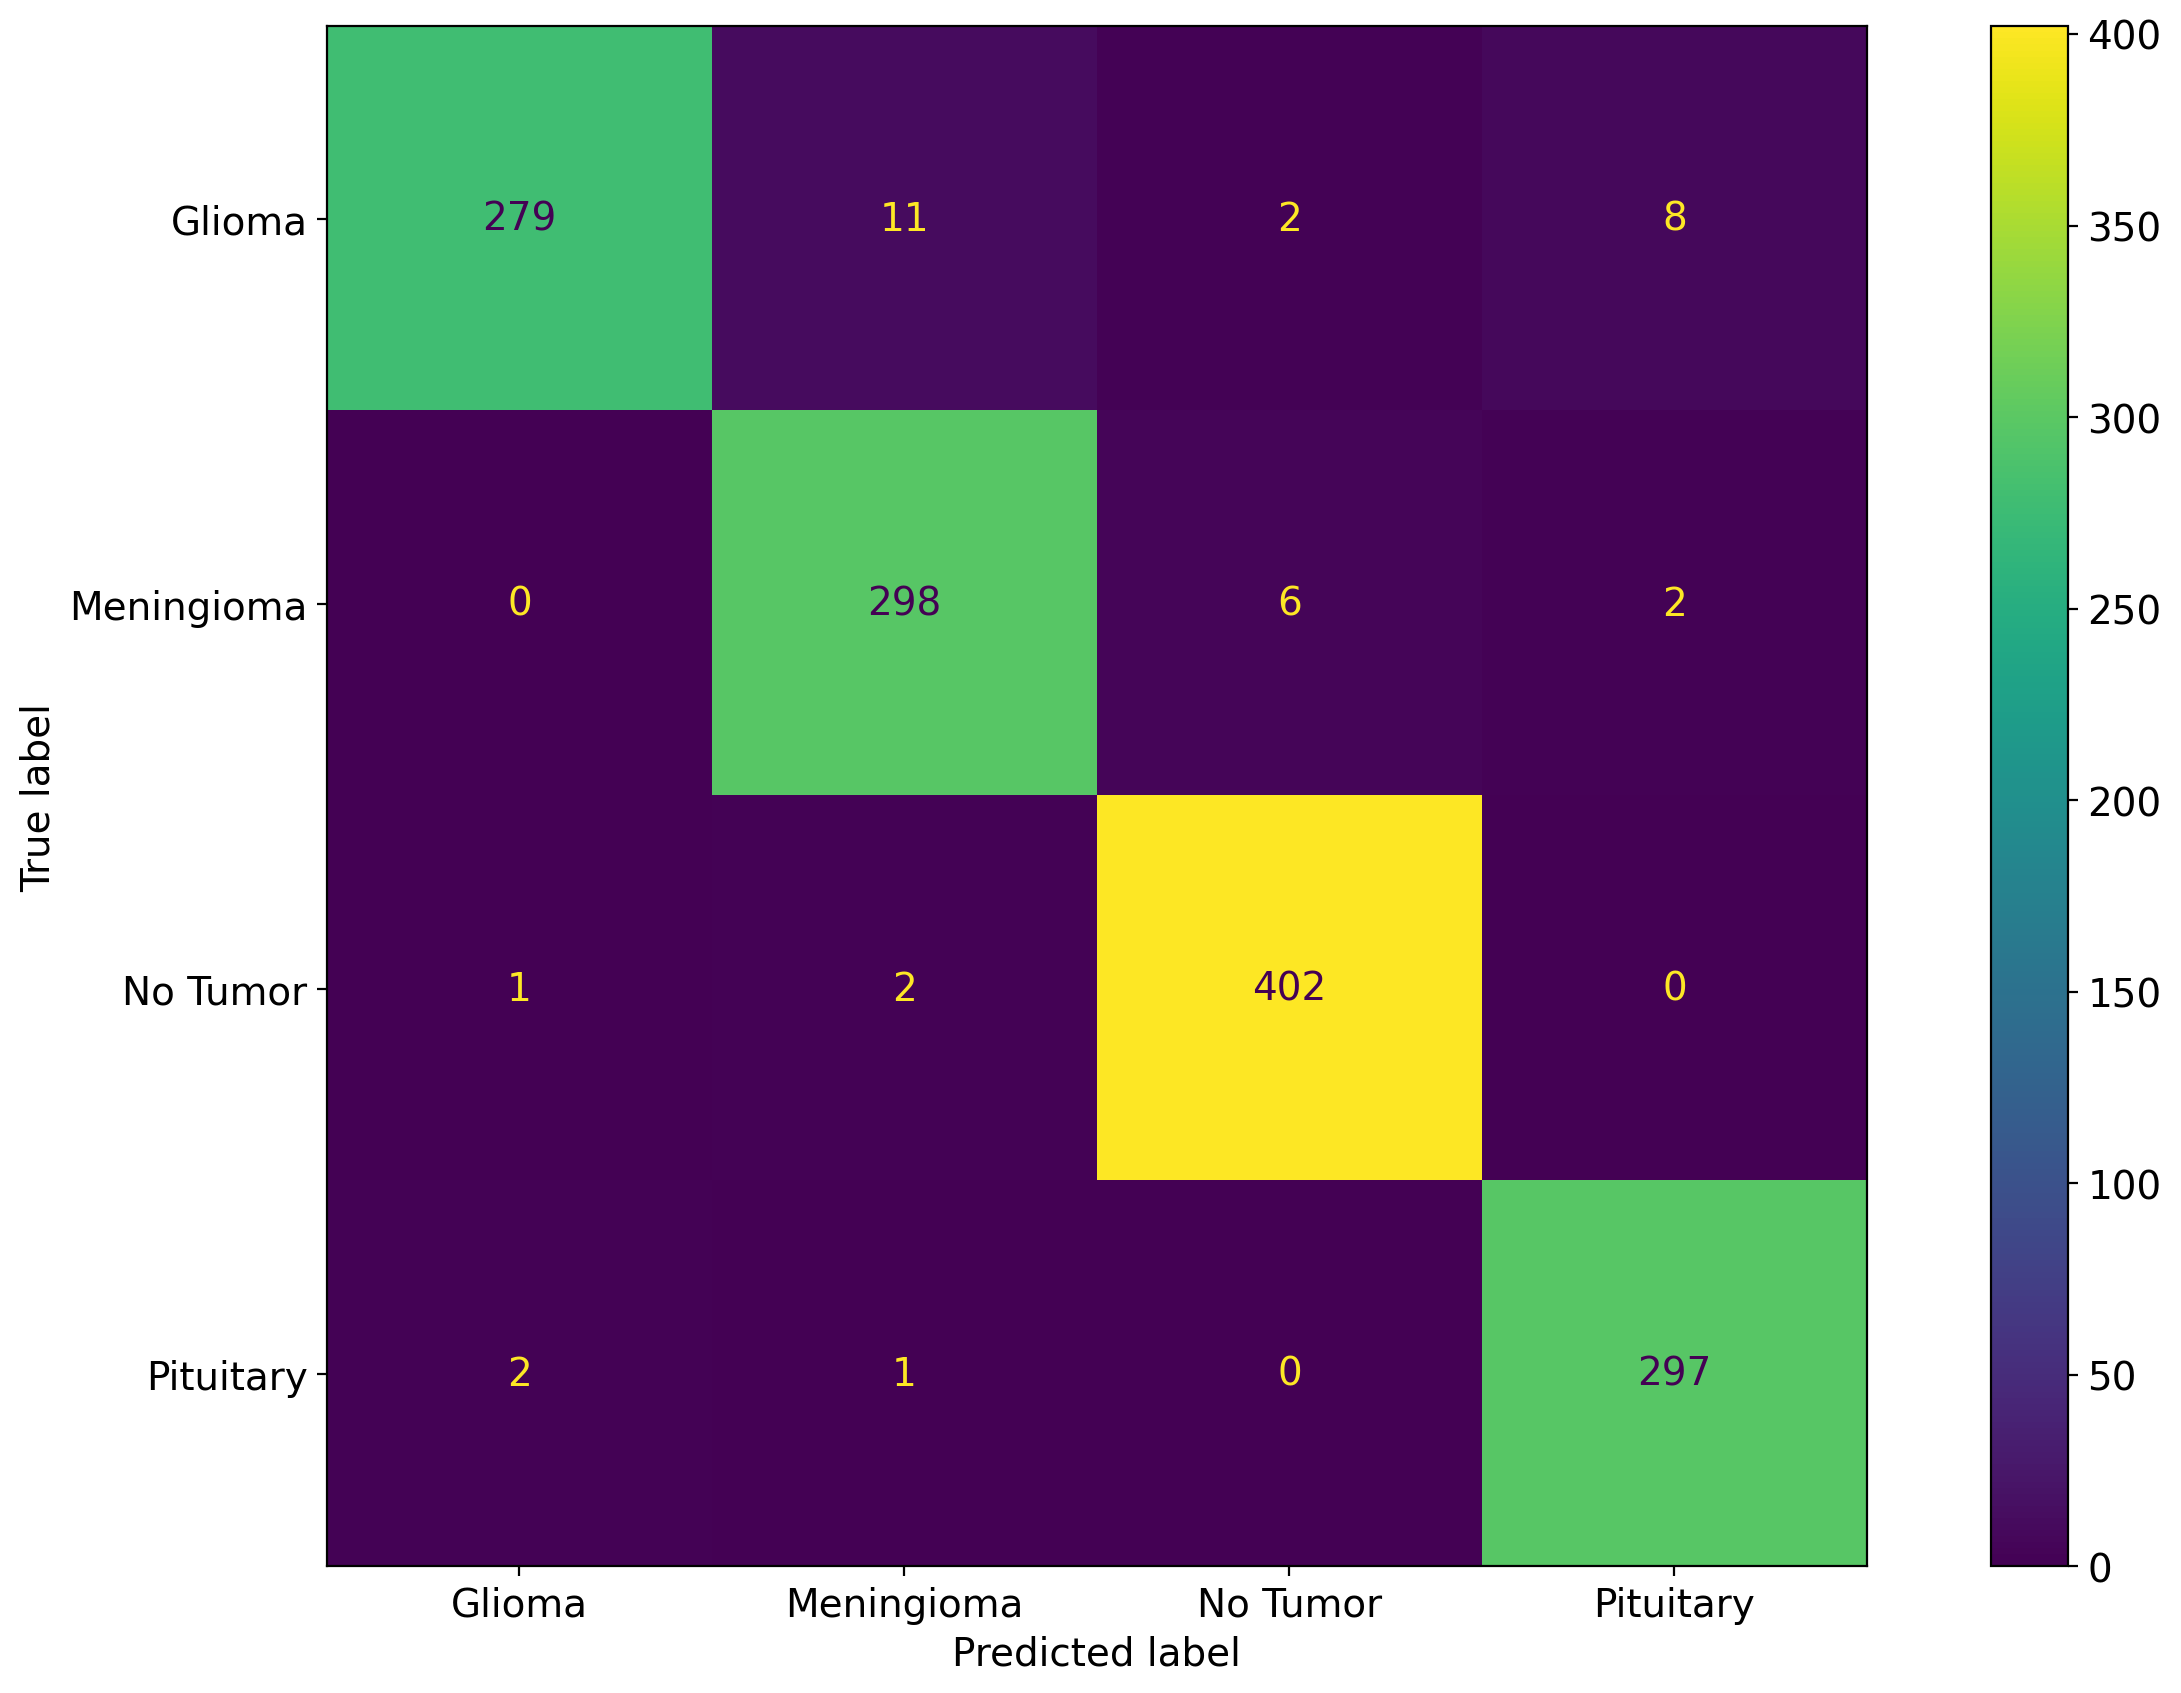

In [58]:
from sklearn.metrics import ConfusionMatrixDisplay
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=class_names)
disp.plot()
plt.show()

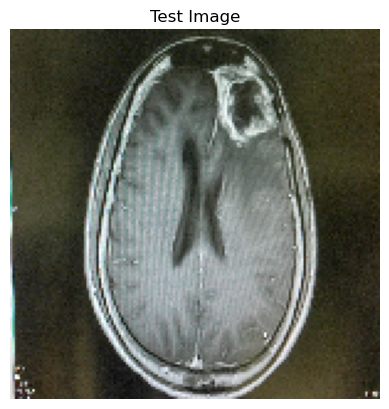

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
Predicted Class: [2]


In [9]:
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt

# Step 1: Load your trained model
model = load_model('best_acc.keras')  # Replace with actual model path

# Step 2: Load and preprocess the test image
img_path = 'test.png'  # Replace with actual image path
img = image.load_img(img_path, target_size=(150, 150))

plt.imshow(img)
plt.axis('off')
plt.title("Test Image")
plt.show()

# Convert image to array and preprocess
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array = img_array / 255.0  # Normalize if needed

# Step 3: Predict the class
predictions = model.predict(img_array)
predicted_class = np.argmax(predictions, axis=1)

print(f"Predicted Class: {predicted_class}")

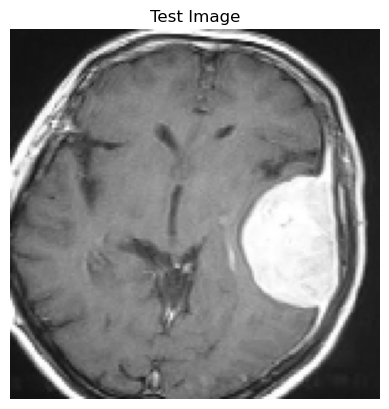

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
Predicted Class Index: 1
Predicted Tumor Type: Meningioma


In [14]:
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt

# Step 1: Load your trained model
model = load_model('best_acc.keras')  # Replace with actual model path

# Step 2: Load and preprocess the test image
img_path = 'test.jpg'  # Replace with actual image path
img = image.load_img(img_path, target_size=(150, 150))  # match model input size

plt.imshow(img)
plt.axis('off')
plt.title("Test Image")
plt.show()

# Convert image to array and preprocess
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array = img_array / 255.0  # normalize to match training

# Step 3: Predict the class
predictions = model.predict(img_array)
predicted_class = np.argmax(predictions, axis=1)[0]

# Step 4: Map to label
label_map = {
    0: "Glioma",
    1: "Meningioma",
    2: "No Tumor",
    3: "Pituitary"
}

print(f"Predicted Class Index: {predicted_class}")
print(f"Predicted Tumor Type: {label_map[predicted_class]}")


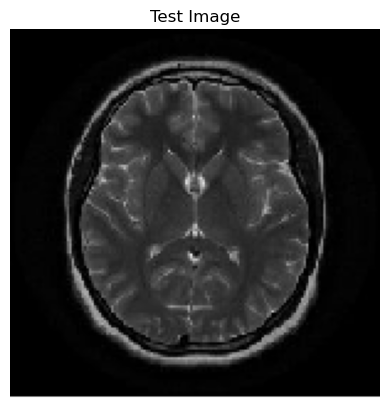

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Predicted Class Index: 2
Predicted Tumor Type: No Tumor


In [15]:
img_path = 'test2.jpg'  # Replace with actual image path
img = image.load_img(img_path, target_size=(150, 150))  # match model input size

plt.imshow(img)
plt.axis('off')
plt.title("Test Image")
plt.show()

# Convert image to array and preprocess
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array = img_array / 255.0  # normalize to match training

# Step 3: Predict the class
predictions = model.predict(img_array)
predicted_class = np.argmax(predictions, axis=1)[0]

# Step 4: Map to label
label_map = {
    0: "Glioma",
    1: "Meningioma",
    2: "No Tumor",
    3: "Pituitary"
}

print(f"Predicted Class Index: {predicted_class}")
print(f"Predicted Tumor Type: {label_map[predicted_class]}")


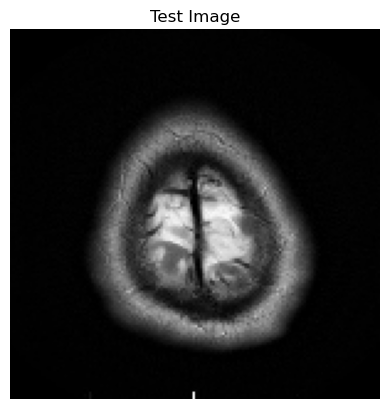

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Predicted Class Index: 0
Predicted Tumor Type: Glioma


In [17]:
img_path = 'test3.jpeg'  # Replace with actual image path
img = image.load_img(img_path, target_size=(150, 150))  # match model input size

plt.imshow(img)
plt.axis('off')
plt.title("Test Image")
plt.show()

# Convert image to array and preprocess
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array = img_array / 255.0  # normalize to match training

# Step 3: Predict the class
predictions = model.predict(img_array)
predicted_class = np.argmax(predictions, axis=1)[0]

# Step 4: Map to label
label_map = {
    0: "Glioma",
    1: "Meningioma",
    2: "No Tumor",
    3: "Pituitary"
}

print(f"Predicted Class Index: {predicted_class}")
print(f"Predicted Tumor Type: {label_map[predicted_class]}")
